## EX_06 네이버 영화리뷰 감성분석 

### 목표: IMDb나 네이버 영화 리뷰 텍스트에 담긴 이용자의 감성이 긍정적인지 혹은 부정적인지를 분류(Classification) 할 수 있는 딥러닝 모델 만들기

- keyword: RNN/ LSTM/ 워드 임베딩(word embedding) 기법/genism 활용/ 1-D CNN/ GlobalMaxPooling1D() layer/ FFN(FeedForward Network) layer/ Transformer layer/ Word2Vec/ 데이터 분석및 가공, 시각화에 대해 더 깊히 공부하기

#### lubric: 
1. 3가지 이상의 모델을 활용하여 Text Classification 태스크를 성공적으로 구현하였다.
2. gensim을 유사단어 찾기를 활용하여 자체학습된 임베딩과 사전학습된 임베딩 레이어를 분석하였다.
3. 한국어 Word2Vec을 활용하여 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성하였다.

#### sequnce:
1. data) 데이터 준비와 확인> load_data 구성> 데이터 분석 및 가공
2. model) validation set 구성> 모델 구성> 모델 훈련> Loss, Accuracy 그래프 시각화
3. 학습된 Embedding 레이어 분석
4. 한국어 Word2Vec 임베딩 활용하여 성능 개선

#### trial and error

## 1. 데이터 준비와 확인

In [1]:
# 필요한 라이브러리 import
import glob
import os
import re
import numpy as np
import pandas as pd

from collections import Counter

import urllib.request
from konlpy.tag import Okt, Mecab

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant

from gensim.models import KeyedVectors
import gensim
from sklearn.model_selection import train_test_split

from keras.layers import Bidirectional, LSTM, GRU, Dense, Conv1D
from keras.layers import Embedding, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 훈련 데이터, 테스트 데이터 준비
train_data = pd.read_table('~/aiffel/EXPLORATIONS/EX_06/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/EXPLORATIONS/EX_06/sentiment_classification/data/ratings_test.txt')

In [34]:
# 훈련 데이터 살펴보기
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [35]:
# 테스트 데이터 살펴보기(위와 같은 의미, 다른 방식, 위엔 trainset 이건 testset)
test_data.head(5)

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [3]:
# data의 갯수 확인
print("train data: {}, test data: {}".format(len(train_data), len(test_data)))

train data: 150000, test data: 50000


## > data_loader 구성

nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일. data_loader 안에서는 다음을 수행.

1. 데이터의 중복 제거
2. NaN 결측치 제거
3. 불용어(Stopwords) 제거
4. 한국어 토크나이저로 토큰화
5. 사전word_to_index 구성
6. 텍스트 스트링을 사전 인덱스 스트링으로 변환
7. X_train, y_train, X_test, y_test, word_to_index 리턴

In [4]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

def load_data(train_data, test_data, num_words=10000):
    # train data 전처리
    train_data.drop_duplicates(subset=['document'], inplace=True) #document 열의 중복 제거
    train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") #한글과 공백을 제외하고 모두 제거
    train_data['document'].replace('', np.nan, inplace=True) # 공백은 Nan 값으로 변경
    train_data = train_data.dropna(how = 'any') # Nan값 결측치 제거
    
    # test data 전처리
    test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열의 중복 제거
    test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") #한글과 공백을 제외하고 모두 제거
    test_data['document'].replace('', np.nan, inplace=True) # 공백은 Nan 값으로 변경
    test_data = test_data.dropna(how='any') # Nan값 제거

    tokenizer = Mecab()
    stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
    # stopwords: 불용어

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 삭제
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) #토큰화
        temp_X = [word for word in temp_X if not word in stopwords] #불용어 삭제
        X_test.append(temp_X)

    
    #단어사전
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)} # 5. 사전word_to_index 구성
        
    def wordlist_to_indexlist(wordlist):   # 6. 텍스트 스트링을 사전 인덱스 스트링으로 변환
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    # 7. X_train, y_train, X_test, y_test, word_to_index 리턴
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
print("train data 개수: {}, test data 개수: {}".format(len(X_train), len(X_test)))

/tmp/ipykernel_13/3733813125.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") #한글과 공백을 제외하고 모두 제거
/tmp/ipykernel_13/3733813125.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") #한글과 공백을 제외하고 모두 제거


train data 개수: 145791, test data 개수: 48995


In [5]:
# 인덱스:단어(키:값) 형태의 딕셔너리 생성
index_to_word = {index:word for word, index in word_to_index.items()}

In [6]:
word_to_index["<PAD>"] = 0  # 패딩
word_to_index["<BOS>"] = 1  # 모든 문장의 시작
word_to_index["<UNK>"] = 2  # Unknown을 의미

In [7]:
# 문장 1개를 활용할 딕셔너리와 함께 주면 단어 인덱스 리스트 벡터로 변환해 주는 함수 
# 모든 문장은 <BOS>로 시작하도록 설정 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode해 주는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

for i in range(10):
    print(X_train[i])
    print(get_decoded_sentence(X_train[i], index_to_word))
    print('Label: ', y_train[i])

[27, 67, 895, 33, 214, 15, 28, 699]
더 빙 진짜 짜증 나 네요 목소리
Label:  0
[977, 481, 491, 636, 4, 110, 1554, 48, 866, 949, 11, 38, 364]
포스터 보고 초딩 영화 줄 오버 연기 조차 가볍 지 않 구나
Label:  1
[19, 192, 3]
재 
Label:  0
[8035, 143, 4134, 277, 85, 13, 5, 52, 3326]
이야기 구먼 솔직히 재미 없 다 평점 조정
Label:  0
[3, 8488, 1051, 48, 2702, 54, 4, 2625, 34, 1118, 29, 326, 36, 17, 35, 54, 3, 3, 393, 2850, 1677, 5]
익살 스런 연기 돋보였 던 영화 스파이더맨 에서 늙 어 보이 기 만 했 던   너무나 이뻐 보였 다
Label:  1
[627, 3, 3, 425, 171, 1464, 661, 1592, 665, 46, 3, 4, 61, 2167, 118, 718]
  세 부터 초등 학교 학년 생 인  영화 ㅋㅋㅋ 별반 개 아까움
Label:  0
[237, 351, 8, 354, 1909, 51, 11, 780, 5]
긴장감 을 제대로 살려 내 지 못했 다
Label:  0
[232, 1344, 132, 5, 392, 705, 3, 3, 48, 1434, 269, 93, 233, 23, 882, 24, 321, 608, 501, 475, 546, 5, 3165, 8489, 17, 1386, 1386, 65, 282, 13, 5, 48, 95, 7, 70, 17, 3, 37]
반개 아깝 다 욕 나온다   연기 생활 몇 년 인지 정말 발 로 해도 그것 보단 낫 겟 다 납치 감금 만 반복 반복 드라마 가족 없 다 연기 못 하 사람 만  네
Label:  0
[117, 13, 18, 85, 12, 269, 22, 43, 4]
없 는데 재미 있 몇 안 되 영화
Label:  1
[57, 612, 52, 225, 706, 53

## > 데이터 분석 및 가공

1. 데이터셋 내 문장 길이 분포
2. 적절한 최대 문장 길이 지정
3. keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [8]:
total_data_text = list(X_train) + list(X_test)
# 텍스트 데이터 문장 길이의 리스트 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장 길이의 평균값, 최대값, 표준편차 각각 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}% 정도가 maxlen 설정값 이내에 포함되어 있다 '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)*100))

문장길이 평균 :  13.757179674103888
문장길이 최대 :  83
문장길이 표준편차 :  11.462771769216866
pad_sequences maxlen :  36
전체 문장의 93.38145451931864% 정도가 maxlen 설정값 이내에 포함되어 있다 


In [9]:
# padding을 통해 문장의 길이를 맞춰준다

x_train = pad_sequences(X_train,
                        value=word_to_index["<PAD>"],
                        padding='post', # 혹은 'pre'
                        maxlen=maxlen)

x_test = pad_sequences(X_test,
                       value=word_to_index["<PAD>"],
                       padding='post', # 혹은 'pre'
                       maxlen=maxlen)

print(x_train.shape)
print(x_test.shape)

(145791, 36)
(48995, 36)


## 2. model) validation set 구성> 모델> 훈련> 시각화

In [10]:
# 훈련 데이터 앞쪽 40000개 까지 validation set으로 사용
x_val = x_train[:40000]   
y_val = y_train[:40000]

# validation set을 제외한 나머지는 모두 훈련 데이터로 사용
partial_x_train = x_train[40000:]  
partial_y_train = y_train[40000:]

print(x_val.shape)
print(y_val.shape)
print(partial_x_train.shape)
print(partial_y_train.shape)

(40000, 36)
(40000,)
(105791, 36)
(105791,)


** 만들 수 있는 모델의 종류 **

RNN인 LSTM /1-D CNN/ GlobalMaxPooling1D() / 
1-D CNN과 RNN 레이어 mix/ FFN(FeedForward Network) / Transformer 등등

# 1. LSTM

In [12]:
# 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용 

vocab_size = 10000  # 어휘 사전의 크기
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(32))    #LSTM state 벡터의 차원수
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                6272      
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 166,817
Trainable params: 166,817
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',  #loss hyper parameter에 주의
             metrics=['accuracy'])

epochs=5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,   #배치사이즈? 
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
207/207 [==============================] - 5s 8ms/step - loss: 0.5323 - accuracy: 0.6953 - val_loss: 0.3739 - val_accuracy: 0.8310
Epoch 2/5
207/207 [==============================] - 1s 6ms/step - loss: 0.3553 - accuracy: 0.8458 - val_loss: 0.3668 - val_accuracy: 0.8387
Epoch 3/5
207/207 [==============================] - 1s 6ms/step - loss: 0.3323 - accuracy: 0.8574 - val_loss: 0.3609 - val_accuracy: 0.8396
Epoch 4/5
207/207 [==============================] - 1s 6ms/step - loss: 0.3183 - accuracy: 0.8632 - val_loss: 0.3648 - val_accuracy: 0.8405
Epoch 5/5
207/207 [==============================] - 1s 6ms/step - loss: 0.3082 - accuracy: 0.8675 - val_loss: 0.3633 - val_accuracy: 0.8395


In [14]:
# LSTM 모델 평가

results = model.evaluate(x_test, y_test, verbose=2) # verbose 공부
print(results)

1532/1532 - 3s - loss: 0.3691 - accuracy: 0.8350
[0.36909019947052, 0.8350443840026855]


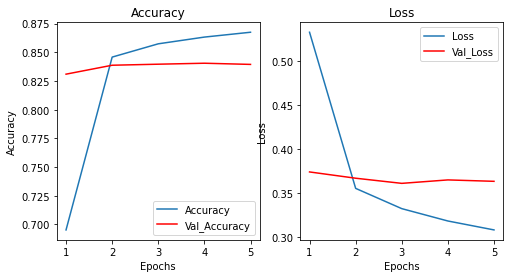

In [15]:
# Accuracy, Loss 그래프 시각화

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Accuracy')
plt.plot(epochs, val_acc, 'red', label='Val_Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Loss')
plt.plot(epochs, val_loss, 'red', label='Val_Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# 2. CNN

In [159]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(32, 3, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 3, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          1568      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1552      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [160]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

epochs=5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,   #배치사이즈? 
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
207/207 [==============================] - 2s 7ms/step - loss: 0.4976 - accuracy: 0.7596 - val_loss: 0.3754 - val_accuracy: 0.8331
Epoch 2/5
207/207 [==============================] - 1s 6ms/step - loss: 0.3402 - accuracy: 0.8531 - val_loss: 0.3578 - val_accuracy: 0.8424
Epoch 3/5
207/207 [==============================] - 1s 6ms/step - loss: 0.3045 - accuracy: 0.8723 - val_loss: 0.3590 - val_accuracy: 0.8439
Epoch 4/5
207/207 [==============================] - 1s 6ms/step - loss: 0.2759 - accuracy: 0.8862 - val_loss: 0.3695 - val_accuracy: 0.8418
Epoch 5/5
207/207 [==============================] - 1s 6ms/step - loss: 0.2462 - accuracy: 0.9025 - val_loss: 0.3836 - val_accuracy: 0.8422


In [161]:
# CNN모델 평가

results = model.evaluate(x_test, y_test, verbose=2) # verbose 공부
print(results)

1532/1532 - 3s - loss: 0.3894 - accuracy: 0.8387
[0.38944071531295776, 0.8387182354927063]


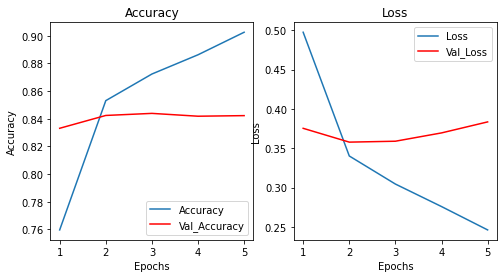

In [162]:
# Accuracy, Loss 그래프 시각화

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Accuracy')
plt.plot(epochs, val_acc, 'red', label='Val_Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Loss')
plt.plot(epochs, val_loss, 'red', label='Val_Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# 3. GlobalMaxPooling1D 

In [163]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [164]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

epochs=5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,   #배치사이즈? 
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
207/207 [==============================] - 1s 5ms/step - loss: 0.6253 - accuracy: 0.6959 - val_loss: 0.4842 - val_accuracy: 0.8103
Epoch 2/5
207/207 [==============================] - 1s 4ms/step - loss: 0.4078 - accuracy: 0.8301 - val_loss: 0.3806 - val_accuracy: 0.8295
Epoch 3/5
207/207 [==============================] - 1s 4ms/step - loss: 0.3462 - accuracy: 0.8539 - val_loss: 0.3655 - val_accuracy: 0.8361
Epoch 4/5
207/207 [==============================] - 1s 4ms/step - loss: 0.3164 - accuracy: 0.8677 - val_loss: 0.3630 - val_accuracy: 0.8401
Epoch 5/5
207/207 [==============================] - 1s 4ms/step - loss: 0.2944 - accuracy: 0.8789 - val_loss: 0.3652 - val_accuracy: 0.8407


In [165]:
# GlobalMaxPooling1D 평가

results = model.evaluate(x_test, y_test, verbose=2)
print(results)

1532/1532 - 2s - loss: 0.3738 - accuracy: 0.8365
[0.3737521469593048, 0.8364934921264648]


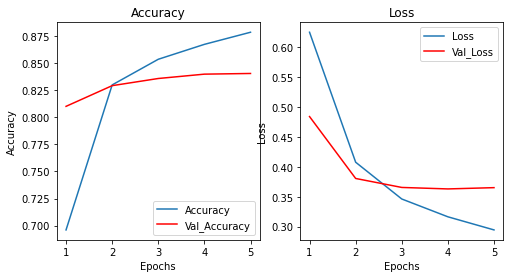

In [166]:
# Accuracy, Loss 그래프 시각화

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Accuracy')
plt.plot(epochs, val_acc, 'red', label='Val_Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Loss')
plt.plot(epochs, val_loss, 'red', label='Val_Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## 3. 학습된 Embedding 레이어 분석

- gensim: 

In [167]:
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

# 임베딩 레이어 차원 확인
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # 출력 형태 : (vocab_size, embedding_dim)

(10000, 16)


In [168]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/EXPLORATIONS/EX_06/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 기록

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [169]:
# 파일에 기록된 임베딩 파라미터를 읽어서 word vector로 활용
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

# 유사한 단어와 그 유사도 확인
word_vectors.similar_by_word("사랑")

[('꾀', 0.901489794254303),
 ('압권', 0.8978198766708374),
 ('전율', 0.8938953876495361),
 ('두말', 0.8908202052116394),
 ('결심', 0.88080894947052),
 ('무상', 0.8651760220527649),
 ('여인', 0.8591076731681824),
 ('훈훈', 0.8540787696838379),
 ('아쉬워', 0.8532572388648987),
 ('해석', 0.8529062271118164)]

'꾀''무상'하고 '아쉬워'(운)'해석'? "사랑?" 알 수 없는 단어가 많다

## 4. 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [29]:
# gensim 패키지 버전 알아보기

import gensim
gensim.__version__

'4.1.2'

gensim 버전을 3.x.x로 낮춰야 오류가 나지 않는다고 해서 downgrade
pip install --upgrade gensim==3.8.3

In [58]:
import gensim
gensim.__version__

'3.8.3'

In [70]:
# 한국어 Word2Vec 파일 불러오기

word2vec_path = os.getenv('HOME')+'/aiffel/EXPLORATIONS/EX_06/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['행복']
vector 

/tmp/ipykernel_1011/2398147980.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['행복']


array([-9.37647521e-01,  3.84321630e-01,  2.66711020e+00, -4.90441829e-01,
       -1.87378454e+00,  7.46136725e-01,  2.06848055e-01,  1.17018402e+00,
        1.76071718e-01,  3.52754295e-01,  3.27339917e-01,  6.24713361e-01,
        4.98253882e-01, -2.54079252e-01,  1.86370641e-01,  5.02261400e-01,
        5.70066161e-02,  1.03963447e+00,  4.08005528e-02,  8.49552810e-01,
       -1.51971027e-01,  1.52919903e-01,  4.23378617e-01,  1.98788300e-01,
        1.94235623e+00, -2.86525309e-01,  4.72732335e-01, -2.14849854e+00,
       -1.26080573e+00, -1.48370254e+00, -7.26968274e-02, -5.65377235e-01,
       -1.09561288e+00, -8.93630147e-01,  8.22069585e-01, -4.43008691e-01,
        6.42822444e-01, -1.16659820e+00,  1.46968305e+00,  3.69109273e+00,
       -3.84803802e-01,  1.05108881e+00,  2.13611469e-01, -1.45143092e+00,
        5.02505243e-01,  7.05544576e-02,  1.83592427e+00, -6.79975271e-01,
        3.81043881e-01,  2.86220014e-01, -3.55438769e-01,  4.01191115e-02,
       -2.18128219e-01,  

In [71]:
from gensim.models import KeyedVectors

# 유사한 단어와 그 유사도 확인
word2vec.wv.most_similar("사랑")

[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

In [72]:
vocab_size = 10000     # 단어 사전의 크기(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수

embedding_matrix = np.random.rand(vocab_size, word_vector_dim) # 사전학습된 임베딩 레이어의 차원 수 그대로 따라가는 것이 좋다

#embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩 순서대로 카피
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_1011/2052740127.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_1011/2052740127.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [101]:
# LSTM 모델의 Embedding 레이어 교체

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 36, 200)           2000000   
_________________________________________________________________
lstm_12 (LSTM)               (None, 128)               168448    
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 129       
Total params: 2,168,577
Trainable params: 2,168,577
Non-trainable params: 0
_________________________________________________________________


In [106]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

epochs=10

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,   #배치사이즈? 
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
207/207 [==============================] - 4s 15ms/step - loss: 0.0321 - accuracy: 0.9886 - val_loss: 0.8321 - val_accuracy: 0.8390
Epoch 2/5
207/207 [==============================] - 3s 13ms/step - loss: 0.0300 - accuracy: 0.9892 - val_loss: 0.8859 - val_accuracy: 0.8378
Epoch 3/5
207/207 [==============================] - 3s 13ms/step - loss: 0.0292 - accuracy: 0.9895 - val_loss: 0.8564 - val_accuracy: 0.8407
Epoch 4/5
207/207 [==============================] - 3s 13ms/step - loss: 0.0267 - accuracy: 0.9902 - val_loss: 0.9256 - val_accuracy: 0.8407
Epoch 5/5
207/207 [==============================] - 3s 13ms/step - loss: 0.0253 - accuracy: 0.9908 - val_loss: 0.9050 - val_accuracy: 0.8396


In [107]:
results = model.evaluate(x_test, y_test, verbose=2)
print(results)

1532/1532 - 3s - loss: 0.9068 - accuracy: 0.8384
[0.9068184494972229, 0.8383916616439819]


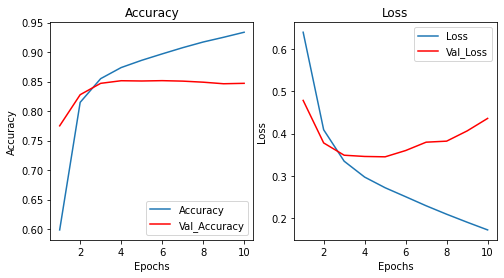

In [85]:
# Accuracy, Loss 그래프 시각화

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Accuracy')
plt.plot(epochs, val_acc, 'red', label='Val_Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Loss')
plt.plot(epochs, val_loss, 'red', label='Val_Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

#### trial and error

accuracy: 0.84구간에서 많이 헤맸다 최소 0.842부터 0.8475까지 하 결국 포기 ^^...

word2vec을 써서 성능을 높히진 못했지만 재밌었다.
저번주에 했던 작사가 만들기와는 또 다르게 이제 어느정도 알겠어!라는 마음으로 임해서 그런지 잘하고 싶었던 NLP노드였다.
1)data_loader를 구성하는 부분에선 조금 벅찼는데 다행히 좋은 자료를 발견해서 하나씩 할 수 있었고
2)각 모델의 하이퍼파라미터를 바꾸는 부분에서 여전히 값을 조정하며 약간은 피곤했지만
3)결국 마지막 성능도 원하는 만큼 높히진 못했지만
이렇게 하는거구나? OK를 알게된 이번 노드.

빨리 하고 있는 다른 게 끝나서 EDA 그리고 모델 공부를 더 자세히 해보고 싶다 :D